## Practical 4a - K-means Clustering (Solution)
In this exercise, we are going to implement *clustering*. The task of clustering is to group a set of data points into several groups (clusters), based on some similarity metric. Clustering is an unsupervised learning method: a clustering algorithm learns the labels itself. For instance, a classification algorithm gets a set of images labeled cats and dogs, and it learns how to recognise cats and dogs on future images. A clustering algorithm can try to spot differences between different images and automatically categorize them into two groups, but not knowing the names for each group. At most it can label them "group 1" and "group 2". 

In this exercise, we shall apply a clustering algorithm called k-means clustering which is already covered in the lecture. We shall use our resale flat data `resale-flat-prices.csv` and derive clusters based on the floor area and resale price. Recall that the fields are delimited by commas and there is a header line indicating names of the fields:
```
month: Month of registration for the resale transactions (format: YYYY-MM)
town: Town the flat is in
flat_type: Type of flat
block: The block number
street_name: The street name
storey_range: The storey range 
floor_area_sqm: Floor area in square metres
flat_model: The flat model
lease_commence_date: The lease commence date (format: YYYY)
resale_price: The resale price in Singapore dollars
```

### Loading the Data
First, create the schema for the dataset and load the dataset into a DataFrame. Since you will be working on the floor area and resale price, select both fields.
```python
from pyspark.sql.types import *

schema = StructType( [
    StructField('month', StringType(), True),
    StructField('town', StringType(), True),
    StructField('flat_type', StringType(), True),
    StructField('block', StringType(), True),
    StructField('street_name', StringType(), True),
    StructField('storey_range', StringType(), True),
    StructField('floor_area', DoubleType(), True),
    StructField('flat_model', StringType(), True),    
    StructField('lease_commence_date', DoubleType(), True),
    StructField('resale_price', DoubleType(), True) 
] )

flats = spark.read.csv('/home/training/data/resale-flat-prices.csv', header=True, schema=schema)
flatsDF = flats.select("floor_area", "resale_price").distinct()
flatsDF.persist()
```

In [1]:
from pyspark.sql.types import *

schema = StructType( [
    StructField('month', StringType(), True),
    StructField('town', StringType(), True),
    StructField('flat_type', StringType(), True),
    StructField('block', StringType(), True),
    StructField('street_name', StringType(), True),
    StructField('storey_range', StringType(), True),
    StructField('floor_area', DoubleType(), True),
    StructField('flat_model', StringType(), True),    
    StructField('lease_commence_date', DoubleType(), True),
    StructField('resale_price', DoubleType(), True) 
] )

flats = spark.read.csv('/home/training/data/resale-flat-prices.csv', header=True, schema=schema)
flatsDF = flats.select("floor_area", "resale_price").distinct()
flatsDF.persist()

DataFrame[floor_area: double, resale_price: double]

### Creating transformers
Since the scale of floor area (in square metres) is different from resale price (in Singapore dollars), it would be good to scale both of these features into a standard scale first.
```python
import pyspark.ml.feature as ft

assembler = ft.VectorAssembler(inputCols=["floor_area", "resale_price"], outputCol="features-vec")
scaler = ft.StandardScaler(inputCol="features-vec", outputCol="features")
```

In [2]:
import pyspark.ml.feature as ft

assembler = ft.VectorAssembler(inputCols=["floor_area", "resale_price"], outputCol="features-vec")
scaler = ft.StandardScaler(inputCol="features-vec", outputCol="features")

### Creating an Estimator
We shall use the k-means model with 5 clusters.
```python
import pyspark.ml.clustering as clus
kmeans = clus.KMeans(k = 5, featuresCol = 'features')
```

In [3]:
import pyspark.ml.clustering as clus
kmeans = clus.KMeans(k = 5, featuresCol = 'features')

### Creating a Pipeline
Now, create a Pipeline to pull the different transformations together:
```python
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [assembler, scaler, kmeans] )
```

In [4]:
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [assembler, scaler, kmeans] )

### Fitting the Model
With clustering algorithms, there is no point in having a validation and a training dataset. So, we shall use the entire dataset.
```python
model = pipeline.fit(flatsDF)
clusters = model.transform(flatsDF)
```

In [5]:
model = pipeline.fit(flatsDF)
clusters = model.transform(flatsDF)

Let us take a closer look at the k-means model that is generated.
```python
km = model.stages[2]
summary = km.summary
print("Number of clusters: ", summary.k)
print("Size of (number of data points in) each cluster: ", summary.clusterSizes)
print("The cluster centers are: ", km.clusterCenters())
```

In [6]:
km = model.stages[2]
summary = km.summary
print("Number of clusters: ", summary.k)
print("Size of (number of data points in) each cluster: ", summary.clusterSizes)
print("The cluster centers are: ", km.clusterCenters())

Number of clusters:  5
Size of (number of data points in) each cluster:  [3045, 5198, 5440, 2791, 7665]
The cluster centers are:  [array([3.52304027, 4.20535822]), array([4.63063631, 3.3822118 ]), array([2.35751957, 2.09633104]), array([5.03926257, 4.86330321]), array([3.5397053, 2.6825775])]


We can plot the clusters to visually see them.
```python
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.figure(figsize=(20,10))

for i in range(5):
    ax = sns.regplot(x="floor_area", y="resale_price", label="Cluster " + str(i+1),
                     data=clusters.select("floor_area", "resale_price"). \
                     filter(clusters.prediction == i).toPandas(), fit_reg=False)
ax.set_xlabel("Floor Area (sqm)", size=14)
ax.set_ylabel("Resale Price (S$)", size=14)
ax.set_title("After clustering", size=20)
ax.legend(loc=4, fontsize=14)

plt.show()
```

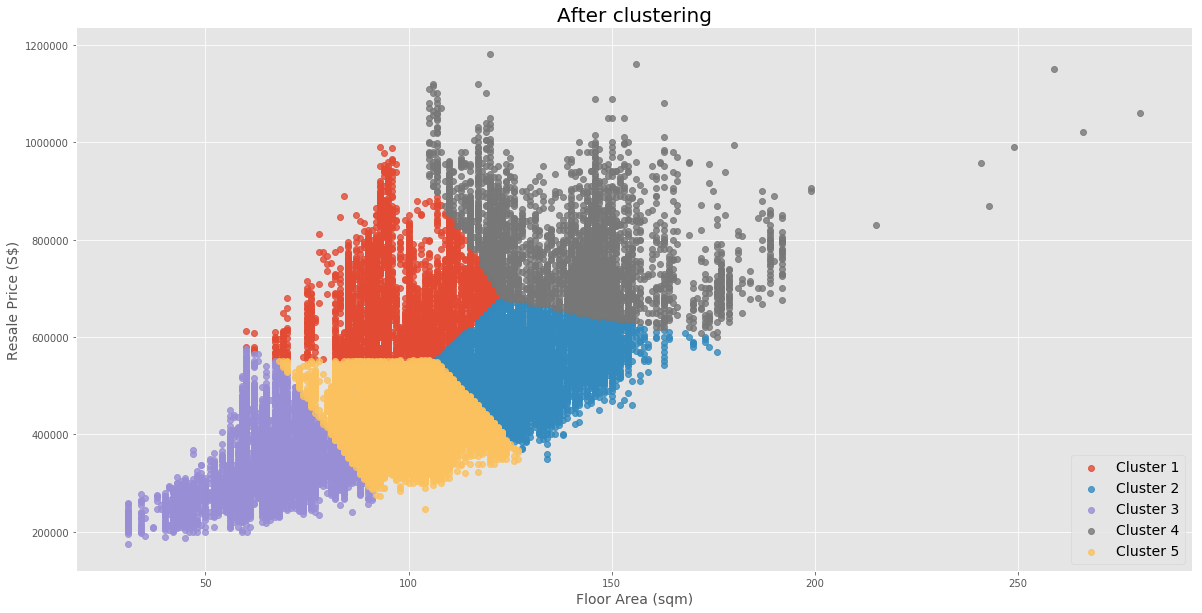

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.figure(figsize=(20,10))

for i in range(5):
    ax = sns.regplot(x="floor_area", y="resale_price", label="Cluster " + str(i+1),
                     data=clusters.filter(clusters.prediction == i) \
                     .select("floor_area", "resale_price").toPandas(), fit_reg=False)
ax.set_xlabel("Floor Area (sqm)", size=14)
ax.set_ylabel("Resale Price (S$)", size=14)
ax.set_title("After clustering", size=20)
ax.legend(loc=4, fontsize=14)

plt.show()

### Evaluating the Performance of the Model
Evaluating clustering models can be difficult because of the nature of the clustering problem: clusters are not known in advance, and it is not easy to separate good and bad clusters. A clustering could be considered good if each data point is near to its closest centroid, where "near" is defined by the Euclidean distance. This is a simple, common way to evaluate the quality of a clustering, by the mean of these distances over all points, or sometimes, the mean of the distances squared. In fact, `KMeansModel` offers a `computeCost` method which computes the sum of squared distances, and can easily be used to compute the mean squared distance.
```python
km.computeCost(clusters) / flatsDF.count()
```

In [8]:
km.computeCost(clusters) / flatsDF.count()

0.37492962286881476